## 2. Scikit-downscale
Scikit-downscale is a new open source Python project. Within Scikit-downscale, we are been curating a collection of new and existing downscaling methods within a common framework. Key features of Scikit-downscale are:

- A high-level interface modeled after the popular `fit` / `predict` pattern found in many machine learning packages ([Scikit-learn](https://scikit-learn.org/stable/index.html), [Tensorflow](https://www.tensorflow.org/guide/keras), etc.),
- Uses [Xarray](http://xarray.pydata.org/en/stable/) and [Pandas](https://pandas.pydata.org/) data structures and utilities for handling of labeled datasets,
- Utilities for automatic parallelization of pointwisde downscaling models,
- Common interface for pointwise and spatial (or global) downscaling models, and
- Extensible, allowing the creation of new downscaling methods through composition.

Scikit-downscale's source code is available on [GitHub](https://github.com/jhamman/scikit-downscale).

### 2.1 Pointwise Models
We define pointwise methods as those that only use local information during the downscaling process. They can be often represented as a general linear model and fit independently across each point in the study domain. Examples of existing pointwise methods are:

- BCSD_[Temperature, Precipitation]: Wood et al. (2004)
- ARRM: Stoner et al. (2012)
- (Hybrid) Delta Method (e.g. Hamlet et al. (2010)
- [GARD](https://github.com/NCAR/GARD): Gutmann et al (in prep). 

Because pointwise methods can be written as a stand-alone linear model, Scikit-downscale implements these models as a Scikit-learn [LinearModel](https://scikit-learn.org/stable/modules/linear_model.html) or [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). By building directly on Scikit-learn, we inherit a well defined model API and the ability to interoperate with a robust ecosystem utilities for model evaluation and optimization (e.g. grid-search). Perhaps more importantly, this structure also allows us to compare methods at a high-level of granularity (single spatial point) before deploying them on large domain problems.

-------

***Begin interactive demo***

-------

From here forward in this notebook, we'll jump back and forth between Python and text cells to describe how scikit-downscale works.

This first cell just imports some libraries and get's things setup for our analysis to come.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils import get_sample_data

sns.set(style='darkgrid')

Now that we've imported a few libraries, let's open a sample dataset from a single point in North America. We'll use this data to explore Scikit-downscale and its existing functionality. You'll notice there are two groups of data, `training` and `targets`. The `training` data is meant to represent data from a typical climate model and the `targets` data is meant to represent our "observations". For the purpose of this demonstration, we've choosen training data sampled from a regional climate model (WRF) run at 50km resolution over North America. The observations are sampled from the nearest 1/16th grid cell in Livneh et al, 2013.

We have choosen to use the `tmax` variable (daily maximum surface air temperature) for demonstration purposes. With a small amount of effort, an interested reader could swap `tmax` for `pcp` and test these methods on precipitation.

training               targets          
                 tmax           pcp    tmax       pcp
time                                                 
1950-01-01        NaN           NaN   -0.22  5.608394
1950-01-02        NaN           NaN   -4.54  2.919726
1950-01-03        NaN           NaN   -7.87  3.066762
1950-01-04        NaN           NaN   -5.08  4.684164
1950-01-05        NaN           NaN   -0.79  4.295568
...               ...           ...     ...       ...
2015-11-26   7.657013  0.000000e+00     NaN       NaN
2015-11-27   7.687256  0.000000e+00     NaN       NaN
2015-11-28  10.480835  0.000000e+00     NaN       NaN
2015-11-29  11.728516  0.000000e+00     NaN       NaN
2015-11-30  10.285431  3.152419e-13     NaN       NaN

[24075 rows x 4 columns]

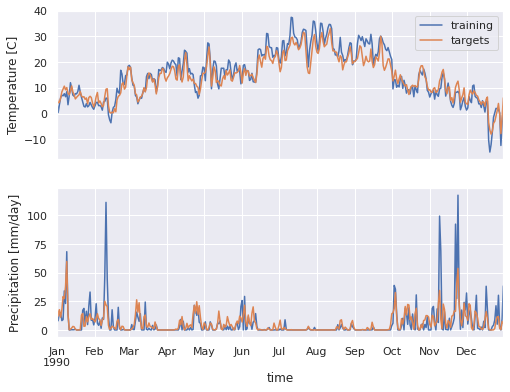

In [2]:
# load sample data
training = get_sample_data('training')
targets = get_sample_data('targets')

# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['tmax'].plot(ax=axes[0], label='training')
targets[time_slice]['tmax'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Temperature [C]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

(7671, 1) (7671, 1) (5753, 1) (1918, 1) (5753, 1) (1918, 1)
kmeans 0.902536292746936
uniform 0.9022388123272804
quantile 0.9020445777722628


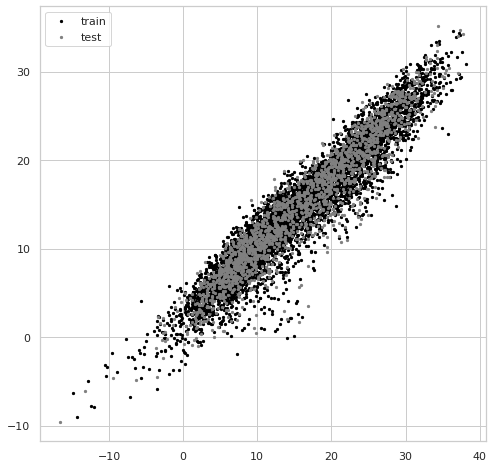

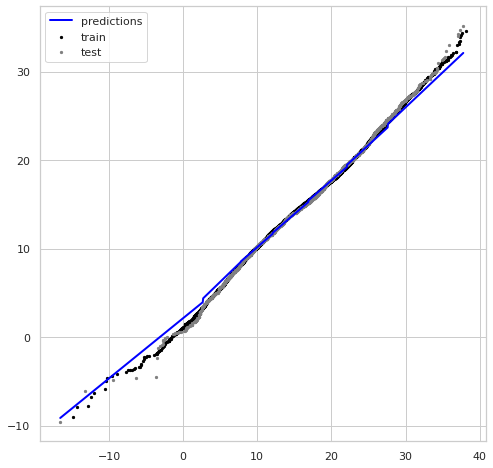

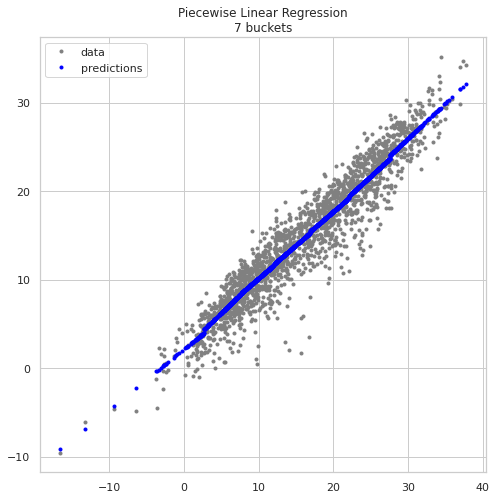

In [3]:
# exploratory data analysis for arrm model

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from mlinsights.mlmodel import PiecewiseRegressor

def ARRM(n_bins=7):
    return Pipeline([
        ('')
    ])


sns.set(style='whitegrid')
c = {'train': 'black', 'predict': 'blue', 'test': 'grey'}

qqwargs = {'n_quantiles': 1e6, 'copy': True, 'subsample': 1e6}
n_bins = 7

X = training[['tmax']]['1980': '2000'].values
y = targets[['tmax']]['1980': '2000'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)
xqt = QuantileTransformer(**qqwargs).fit(X_train)
Xq_train = xqt.transform(X_train)
Xq_test = xqt.transform(X_test)

yqt = QuantileTransformer(**qqwargs).fit(y_train)
yq_train = xqt.transform(y_train)[:, 0]
yq_test = xqt.transform(y_test)[:, 0]


print(X.shape, y.shape, X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='quantile'))
# model.fit(Xq_train, yq_train)
# predq = model.predict(Xq_test)
# pred = qt.inverse_transform(predq.reshape(-1, 1))

y_train = y_train[:, 0]
for strat in ['kmeans', 'uniform', 'quantile']:
    model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy=strat))

    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(strat, model.score(X_test, y_test))
    
model = PiecewiseRegressor(binner=KBinsDiscretizer(n_bins=n_bins, strategy='kmeans'))
model.fit(X_train, y_train)
pred = model.predict(X_test)


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(X_train, y_train, c=c['train'], s=5, label='train')
plt.scatter(X_test, y_test, c=c['test'], s=5, label='test')
ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.scatter(np.sort(X_train, axis=0), np.sort(y_train, axis=0), c=c['train'], s=5, label='train')
plt.scatter(np.sort(X_test, axis=0), np.sort(y_test, axis=0), c=c['test'], s=5, label='test')
plt.plot(np.sort(X_test, axis=0), np.sort(pred, axis=0), c=c['predict'], lw=2, label='predictions')
ax.legend()

# fig, ax = plt.subplots(1, 1)
# ax.plot(Xq_test[:, 0], yq_test, ".", label='data', c=c['test'])
# ax.plot(Xq_test[:, 0], predq, ".", label="predictions", c=c['predict'])
# ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(X_test[:, 0], y_test, ".", label='data', c=c['test'])
ax.plot(X_test[:, 0], pred, ".", label="predictions", c=c['predict'])
ax.set_title(f"Piecewise Linear Regression\n{n_bins} buckets")
ax.legend()


### 2.2 Models as cattle, not pets

As we mentioned above, Scikit-downscale utilizes a similiar API to that of Scikit-learn for its pointwise models. This means we can build collections of models that may be quite different internally, but operate the same at the API level. Importantly, this means that all downscaling methods have two common API methods: `fit`, which trains the model given _training_ and _targets_ data, and `predict` which uses the fit model to perform the downscaling opperation. This is perhaps the most important feature of Scikit-downscale, the ability to test and compare arbitrary combinations of models under a common interface. This allows us to try many combinations of models and parameters, choosing only the best combinations. The following pseudo-code block describe the workflow common to all scikit-downscale models:

```python
from skdownscale.pointwise_models import MyModel

...
# load and pre-process input data (X and y)
...

model = MyModel(**parameters)
model.fit(X_train, y)
predictions = model.predict(X_predict)

...
# evaluate and/or save predictions
...


```

In the cell below, we'll create nine different downscaling models, some from Scikit-downscale and some from Scikit-learn.

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')


Now that we've created a collection of models, we want to train the models on the same input data. We do this by looping through our dictionary of models and calling the `fit` method:

In [5]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

Just like that, we fit nine downscaling models. Now we want to use those models to downscale/bias-correct our data. For the sake of easy comparison, we'll use a different part of the training data:

In [6]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    predict_df[key] = model.predict(X_predict)

# show a table of the predicted data
display(predict_df.head())

,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor
time,,,,,,,,,
1990-01-01,4.50,2.61,5.375299,5.697786,5.895,5.931445,5.781472,4.528703,5.2024
1990-01-02,6.13,3.55,3.543398,3.264698,2.561,2.515919,2.524322,-1.584749,4.6935
1990-01-03,5.46,5.47,4.963575,4.933534,4.692,4.862730,4.944167,2.848937,4.6736
1990-01-04,8.57,5.08,8.369125,8.239455,7.340,7.255379,7.107427,6.687826,8.4134
1990-01-05,5.67,7.00,7.424970,7.583703,7.705,7.711861,7.878299,8.296425,6.5789


Now, let's do some sample analysis on our predicted data. First, we'll look at a timeseries of all the downscaled timeseries for the first year of the prediction period. In the figure below, the `target` (truth) data is shown in black, the original (pre-correction) data is shown in grey, and each of the downscaled data timeseries is shown in a different color.

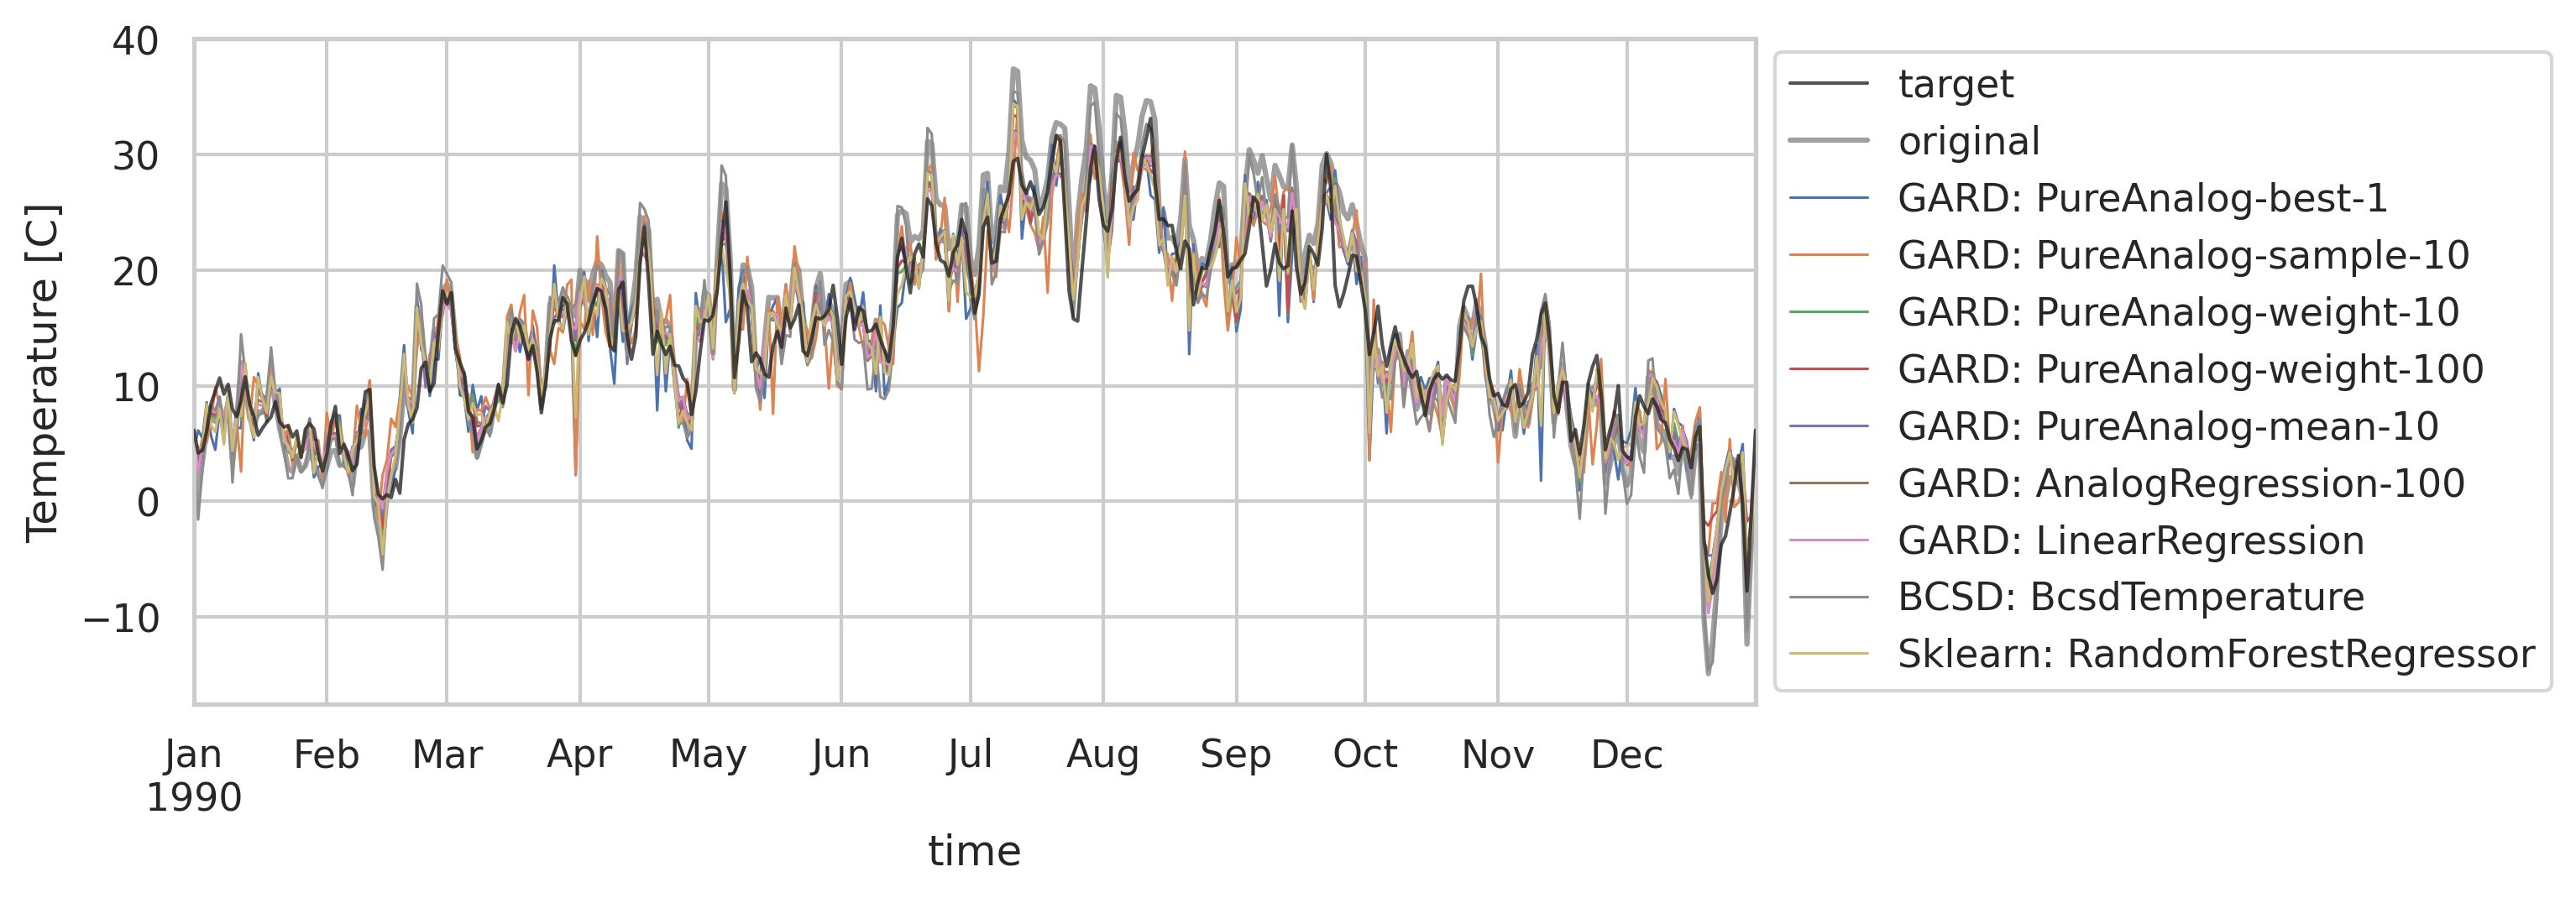

In [7]:
fig, ax = plt.subplots(figsize=(8, 3.5),dpi=300)
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]') # Temperature [C]   Rainfall [mm/day]

Of course, its difficult to tell which of the nine downscaling methods performed best from our plot above. We may want to evaluate our predictions using a standard statistical score, such as $r^2$. Those results are easily computed below:

In [8]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-best-1,0.820385
GARD: PureAnalog-sample-10,0.824389
BCSD: BcsdTemperature,0.858258
Sklearn: RandomForestRegressor,0.864160
GARD: PureAnalog-weight-10,0.881286
GARD: PureAnalog-weight-100,0.892049
GARD: PureAnalog-mean-10,0.899279
GARD: AnalogRegression-100,0.906217
GARD: LinearRegression,0.906316


All of our downscaling methods seem to be doing fairly well. The timeseries and statistics above shows that all our methods are producing generally resonable results. However, we are often interested in how our models do at predicting extreme events. We can quickly look into those aspects of our results using the `qq` plots below. There you'll see that the models diverge in some interesting ways. For example, while the `LinearRegression` method has the highest $r^2$ score, it seems to have trouble capturing extreme heat events. Whereas many of the analog methods, as well as the `RandomForestRegressor`, perform much better on the tails of the distributions.

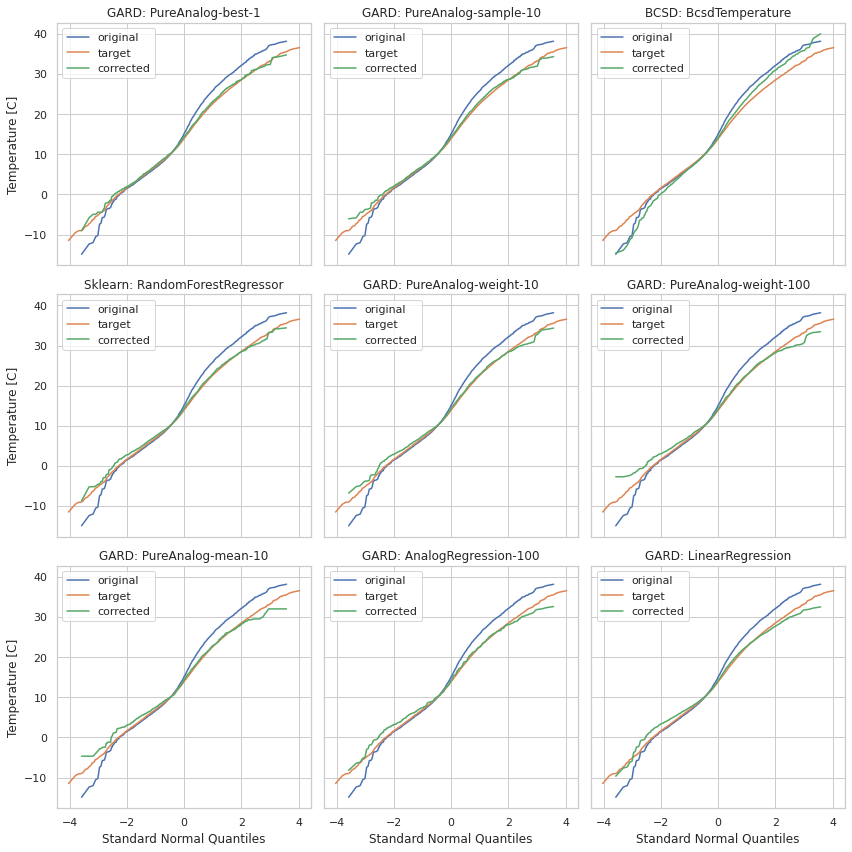

In [9]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))

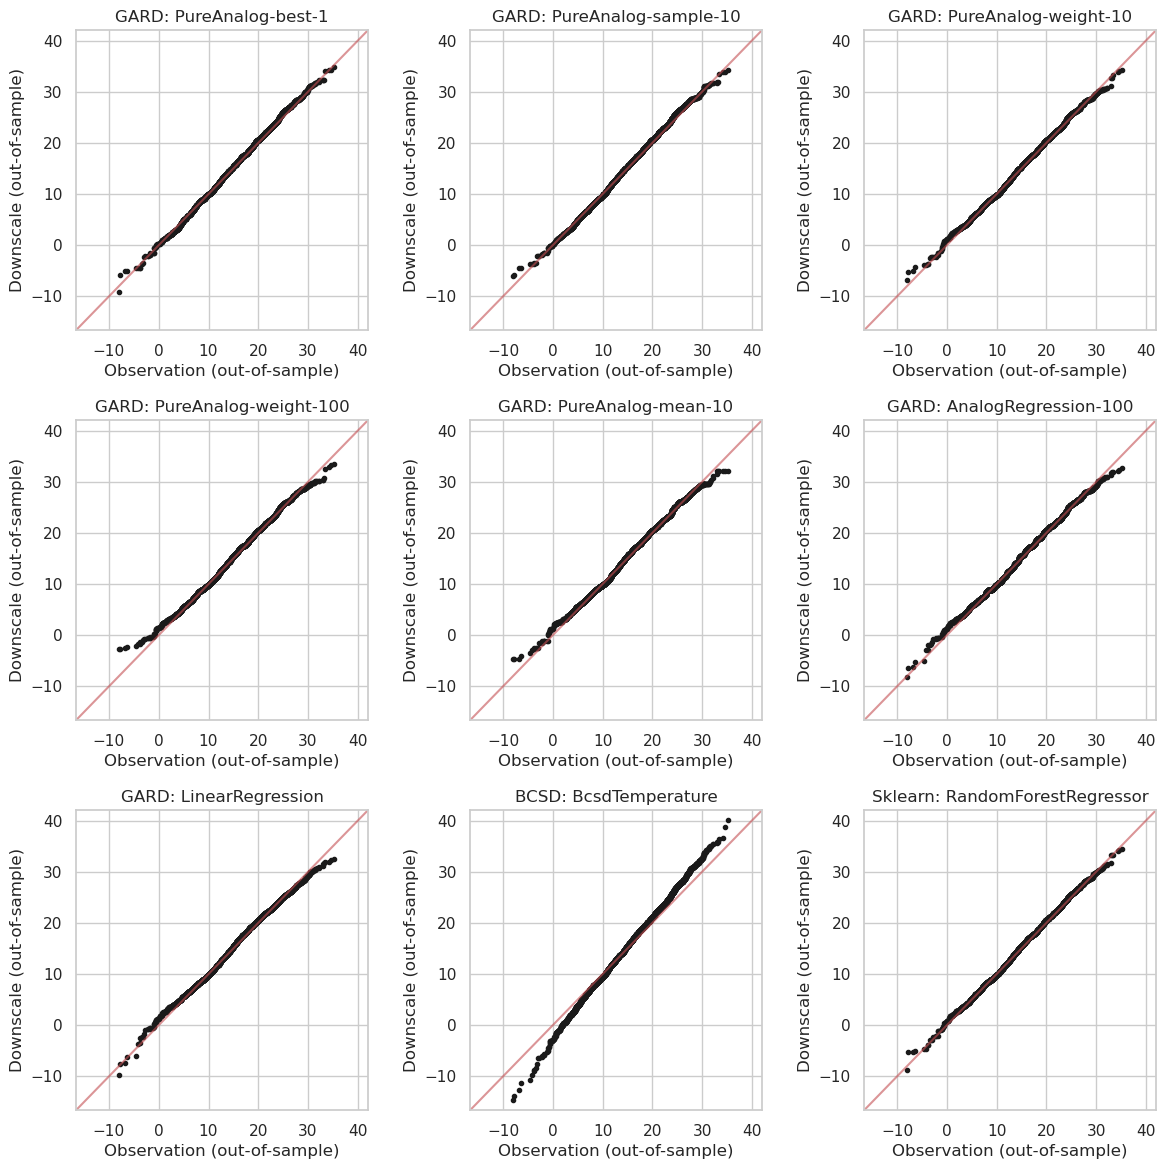

In [10]:
fig,ax=plt.subplots(3,3); fig.set_size_inches(12,12); fig.set_facecolor('w'); fig.set_edgecolor('k');fig.set_dpi(100); 
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.35,hspace=0.3); fontsize = 8

for POS in range(len(ax.flatten())):
    ax.flatten()[POS].plot(np.sort(targets.tmax[predict_slice]),np.sort(predict_df[predict_slice].iloc[:,POS].values),'ok',ms=3)
    ax.flatten()[POS].set_xlabel('Observation (out-of-sample)')
    ax.flatten()[POS].set_ylabel('Downscale (out-of-sample)')
    ax.flatten()[POS].set_title(predict_df.columns[POS])
    tmp_min = np.min([np.min(targets.tmax[predict_slice]),predict_df[predict_slice].min().min()]) - 2
    tmp_max = np.max([np.max(targets.tmax[predict_slice]),predict_df[predict_slice].max().max()]) + 2
    ax.flatten()[POS].plot([tmp_min,tmp_max],[tmp_min,tmp_max],'-r',alpha=.6)
    ax.flatten()[POS].set_xlim(tmp_min,tmp_max)
    ax.flatten()[POS].set_ylim(tmp_min,tmp_max)

In this section, we've shown how easy it is to fit, predict, and evaluate scikit-downscale models. The seamless interoperability of these models clearly facilitates a workflow that enables a deeper level of model evaluation that is otherwise possible in the downscaling world. 

### 2.4 Automatic Parallelization

In the examples above, we have performed downscaling on sample data sourced from individual points. In many downscaling workflows, however, users will want to apply pointwise methods at all points in their study domain. For this use case, scikit-downscale provides a high-level wrapper class: `PointWiseDownscaler`.

In the example below, we'll use the `BCSDTemperature` model, along with the `PointWiseDownscaler` wrapper, to downscale daily maximum surface air temperature from CMIP6 for all point in a subset of the Pacific Norwest. We'll use a local [Dask Cluster](https://dask.org/) to distribute the computation among our available processors. Though not the point of this example, we also use [intake-esm](https://intake-esm.readthedocs.io/en/latest/) to access [CMIP6](https://www.wcrp-climate.org/wgcm-cmip/wgcm-cmip6) data stored on [Google Cloud Storage](https://console.cloud.google.com/marketplace/details/noaa-public/cmip6).

**Data:**
  - Training / Prediction data: NASA-GISS-E2 historical data from CMIP6
  - Targets: [GridMet](http://www.climatologylab.org/gridmet.html) daily maximum surface air temperature

In [11]:
# parameters
train_slice = slice('1981', '1983')  # train time range
holdout_slice = slice('2053', '2055')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -122.0) 
lat_slice = slice(50, 48)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

Step 1: Start a Dask Cluster. Xarray and the `PointWiseDownscaler` will make use of this cluster when it comes time to load input data and train/predict downscaling models. 

In [12]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 40,Total memory: 251.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36953,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 40
Started: Just now,Total memory: 251.71 GiB
Comm: tcp://146.179.44.37:33219,Total threads: 5
Dashboard: http://146.179.44.37:38603/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:37797,


Step 2. Load our target data. 

Here we use xarray directly to load a collection of OpenDAP endpoints. 

<xarray.DataArray 'air_temperature' (time: 1095, lat: 34, lon: 67)>
dask.array<xarray-<this-array>, shape=(1095, 34, 67), dtype=float32, chunksize=(1095, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1983-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 48.15 48.11 48.07 48.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -122.1 -122.1 -122.0

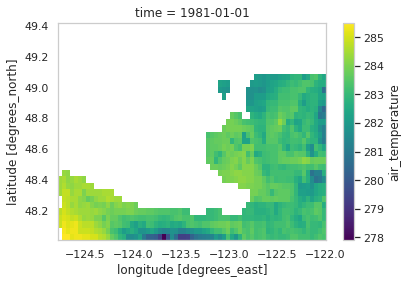

In [13]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='netcdf4', concat_dim='day').rename({'day': 'time'}).drop('crs') #engine='pydap' 

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

Step 3: Load our training/prediction data.

Here we use `intake-esm` to access a single Xarray dataset from the Pangeo's Google Cloud CMIP6 data catalog. 

In [14]:
import intake_esm
intake_esm.__version__

'2021.8.17'

/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/sw1013/anaconda3/envs/downscale/lib/python3.9/site-packages/xarray/core/indexing.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


<xarray.DataArray 'tasmax' (time: 1095, lat: 34, lon: 67)>
dask.array<xarray-<this-array>, shape=(1095, 34, 67), dtype=float32, chunksize=(1095, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2053-01-01 2053-01-02 ... 2055-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 48.15 48.11 48.07 48.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -122.1 -122.1 -122.0

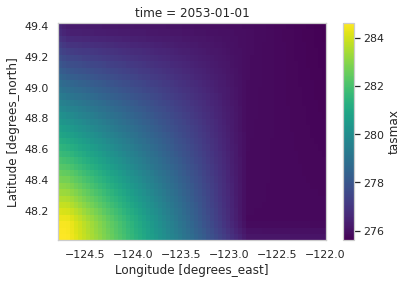

In [15]:
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
# cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
#                  grid_label='gn')
cat = col.search(experiment_id=['historical','ssp585'], table_id='day', variable_id='tasmax',member_id='r1i1p1f1',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time']=pd.to_datetime(train_subset['time'].dt.strftime('%Y-%m-%d'))
# train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)


# access the data and do some cleanup
ds_model = cat['ScenarioMIP.CSIRO-ARCCSS.ACCESS-CM2.ssp585.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time']=pd.to_datetime(holdout_subset['time'].dt.strftime('%Y-%m-%d'))
# holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
# display(train_subset)
# train_subset.isel(time=0).plot()
display(holdout_subset)
holdout_subset.isel(time=0).plot()

Step 4. Now that we have loaded our training and target data, we can move on to fit our BcsdTemperature model at each x/y point in our domain. This is where the `PointWiseDownscaler` comes in:

In [16]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

# model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
model = PointWiseDownscaler(RandomForestRegressor(random_state=0))
model

<skdownscale.PointWiseDownscaler>
  Fit Status: False
  Model:
    RandomForestRegressor(random_state=0)

Step 5. We fit the `PointWiseDownscaler`, passing it data in Xarray data structures (our regional subsets from above). This opperation is lazy and return immediately. Under the hood, we can see that `PointWiseDownscaler._models` is an `Xarray.DataArray` of `BcsdTemperature` models.

<div class="alert-warning">
Note: The following two cells may take a few minutes, or longer, to complete depending on how many cores your computer has, and your internet connection.     
</div>

In [17]:
# model.fit(train_subset, obs_subset)
model.fit(train_subset, train_subset)
display(model, model._models)

<skdownscale.PointWiseDownscaler>
  Fit Status: True
  Model:
    RandomForestRegressor(random_state=0)

<xarray.DataArray 'tasmax' (lat: 34, lon: 67)>
dask.array<<this-array>-_fit_wrapper, shape=(34, 67), dtype=object, chunksize=(10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 48.15 48.11 48.07 48.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -122.1 -122.1 -122.0

Step 6. Finally, we can use our model to complete the downscaling workflow using the `predict` method along with our `holdout_subset` of CMIP6 data. We call the `.load()` method to eagerly compute the data. We end by plotting a map of downscaled data over our study area.

/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/skdownscale/pointwise_models/core.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  scalar_obj[:] = [mod.fit(xdf, ydf, **kwargs)]
/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/skdownscale/pointwise_models/core.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  scalar_obj[:] = [mod.fit(xdf, ydf, **kwargs)]
/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/skdownscale/pointwise_models/core.py:74: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  scalar_obj[:] = [mod.fit(xdf, ydf, **kwargs)]
/net/wrfstore7-10/disk1/sw1013/SINGAPORE/scikit-downscale/examples/

<xarray.DataArray (time: 1095, lat: 34, lon: 67)>
array([[[276.53558, 276.3983 , 276.2711 , ..., 275.6301 , 275.62802,
         275.6018 ],
        [276.66965, 276.53683, 276.4084 , ..., 275.65536, 275.64532,
         275.6291 ],
        [276.94223, 276.8036 , 276.68564, ..., 275.6512 , 275.6318 ,
         275.62973],
        ...,
        [284.55606, 284.5381 , 284.4976 , ..., 275.83817, 275.8443 ,
         275.84534],
        [284.58527, 284.56927, 284.54147, ..., 275.95972, 275.97263,
         275.95627],
        [284.6182 , 284.6019 , 284.5823 , ..., 276.0428 , 276.0836 ,
         276.06635]],

       [[277.8584 , 277.79767, 277.70932, ..., 275.25436, 275.24634,
         275.22998],
        [277.99866, 277.9268 , 277.85925, ..., 275.29703, 275.28543,
         275.27588],
        [278.17908, 278.11624, 277.98123, ..., 275.36237, 275.3552 ,
         275.33896],
...
        [277.59485, 277.53006, 277.4613 , ..., 271.65317, 271.63202,
         271.58307],
        [277.6837 , 277.61862, 277.54767, ..., 271.72058, 271.69513,
         271.66974],
        [277.7739 , 277.70935, 277.6364 , ..., 271.811  , 271.77698,
         271.74677]],

       [[276.31912, 276.21506, 276.14874, ..., 273.85062, 273.81784,
         273.7696 ],
        [276.41193, 276.3221 , 276.25528, ..., 273.88818, 273.8455 ,
         273.79953],
        [276.50793, 276.44113, 276.362  , ..., 273.91846, 273.86563,
         273.82785],
        ...,
        [279.49033, 279.43958, 279.3917 , ..., 274.5104 , 274.44946,
         274.38483],
        [279.53036, 279.4834 , 279.43347, ..., 274.5298 , 274.4685 ,
         274.42737],
        [279.5753 , 279.53128, 279.48538, ..., 274.55557, 274.48108,
         274.42636]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2053-01-01 2053-01-02 ... 2055-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 48.15 48.11 48.07 48.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -122.1 -122.1 -122.0

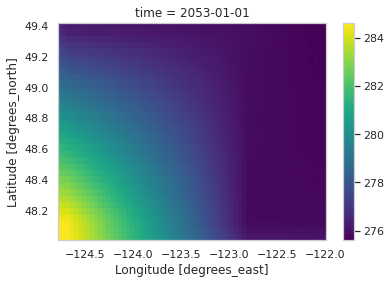

In [18]:
predicted = model.predict(holdout_subset).load()
display(predicted)
predicted.isel(time=0).plot()